# SciPy Implementation 01
`0900.25.Mar.20`

### Explanation

This is an implementation for the IEA case with Dr. Ning's reccommended SNOPT optimizer, as well as the "normal" method boundary that PJ supplied me the code for.

First I'll need to figure out how to use SNOPT, then change the convex hull boundary so it's valid.`0930.25.Mar.20`

Pj just mentioned I should get the convex hull first, then SNOPT. `0952.25.Mar.20`

### Convex Hull Modification
`1030.25.Mar.20`

This is workout to modify the IEA cs3 boundary to be convex and use normals to determine location viability

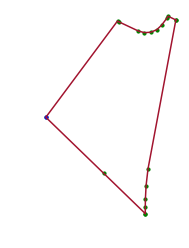

In [248]:
#-- Necessary Headers --#
%run "baker_cs34_functions_sandbox.py"
#-- End Headers --#

colorNum = 1 # Make it Red

printBoundaryClr(clsdBP, colorNum)
printTurbines(clsdBP, 'green', 10)
printTurbines(clsdBP[8], 'Blue', 10)

#testArray = makeCoordArray(clsdBP)
#print(type(testArray))
#print(testArray)

This is going to be a little harder than first expected. There is no algorithm or clear way for me to automate the making of a convex hull out of the boundary. If I use the `ConvexHull()` function, it'll make the area larger, not smaller. I'll have to create the points by hand.

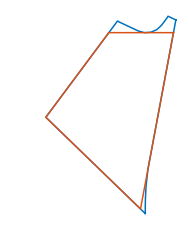

In [154]:
def line(p1, p2):
    # Makes a line from the given <coordinate> points
    A = (p1.y - p2.y)
    B = (p2.x - p1.x)
    C = (p1.x*p2.y - p2.x*p1.y)
    return A, B, -C

def intersection(L1, L2):
    # Finds intersection of the given lines
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False

numVertices = 4 # Our new closed boundary. Will be made of only 4 values, to stay convex
newVertices = np.recarray(4, coordinate) # Our new closed boundary. Will be made of only 4 values, to stay convex

#-- Make our line equations --#
lineRgt = line(clsdBP[0], clsdBP[1])  #- Right side line equation -#
lineBtm =line(clsdBP[6], clsdBP[8])   #- Bottom side line equation -#
lineLft = line(clsdBP[8], clsdBP[9])  #- Left side line equation -#
#- Top side line equation -#
crdTemp =  np.recarray(1, coordinate)
crdTemp.x = 0
crdTemp.y = clsdBP[12].y
lineTop = line(crdTemp[0], clsdBP[12]) # point [12] is the min y-val of that curve

#-- Figure out intersection points --#
[newVertices[0].x, newVertices[0].y] = intersection(lineRgt, lineTop)
[newVertices[1].x, newVertices[1].y] = intersection(lineRgt, lineBtm)
newVertices[2] = clsdBP[8]
[newVertices[3].x, newVertices[3].y] = intersection(lineLft, lineTop)
newVertices = closeBndryList(newVertices) # Close up the loop for plotting

colorNum = 5
printBoundaryClr(clsdBP, colorNum)
printBoundaryClr(newVertices, colorNum+1)
plt.savefig("./figures/ConcaveBoundary.pdf", bbox_inches='tight')

Well that took longer than it should have  `1434.25.Mar.20`

### Finding Normals
`1438.25.Mar.20`

Now that I have a boundary, I'll get the "normal" code to find if a certain point is within the boundary working.
Pj directed me to some code Jared wrote in his GitHub repository under `plantenergy/src/GeneralWindFarmComponents.py`. It seems like I'll have to shave this square peg to fit in my round hole.

In [110]:
def bndryNormals(bndryList):
    # Rewritten and adapted from Jared Thomas' code on 25.Mar.20
    nVerts = len(bndryList)-1             # Number of verticies in our boundary (minus the repeat for closure)
    unit_normals = np.zeros([nVerts, 2])  # For our unit Normals
    unit_normals_coords = np.recarray(nVerts, coordinate)
    
    # determine if point is inside or outside of each face, and distance from each face
    for j in range(nVerts):
        # calculate the unit normal vector of the current face (taking points CCW)
        if j < nVerts:  # all but the set of point that close the shape
            normal = np.array([bndryList[j+1].y -bndryList[j].y,
                               -(bndryList[j+1].x-bndryList[j].x)])
            unit_normals[j] = normal/np.linalg.norm(normal)
        else:   # the set of points that close the shape
            normal = np.array([bndryList[0].y-bndryList[j].y,
                               -(bndryList[0].x-bndryList[j].x)])
            unit_normals[j] = normal/np.linalg.norm(normal)
    
    #Convert to our <coordinate> data type
    for i in range(nVerts):
        unit_normals_coords[i].x = unit_normals[i][0]
        unit_normals_coords[i].y = unit_normals[i][1]
        
    return unit_normals_coords

In [171]:
def convertCoordToArray(Coords):
    # Quick conversion froma list of <coordinate> to a list of vectors
    numPts = Coords.shape[0]
    Array = np.zeros([numPts,2])
    for i in range(numPts):
        Array[i][0] = Coords[i].x
        Array[i][1] = Coords[i].y
        
    return Array

In [201]:
def calcDistNorms(points, vertices, unit_normals):
    # Rewritten and adapted from Jared Thomas' code on 25.Mar.20
    # print points.shape, vertices.shape, unit_normals.shape
    nPoints = points.shape[0]
    nVertices = vertices.shape[0] -1
    face_distance = np.zeros([nPoints, nVertices]) # initialize array to hold distances from each point to each face
    inside = np.zeros(nPoints)        # init bool array indicating whether a pt is in the hull or not
    pa = np.zeros(2)                  # Temp vector from turbine to boundary face
    d_vec = np.zeros(2)               # Temp vector
    #-- Convert from <coordinate> --#
    unit_norms = convertCoordToArray(unit_normals)
    turbCoords = convertCoordToArray(points)
    bndryCoords = convertCoordToArray(vertices) 
    
    for i in range(nPoints):          # loop through pts and find dist to each face
        for j in range(nVertices):    # determine if pt is in or out of each face, and dist from each face
            # define the vector from the point of interest to the first point of the face
            pa = [[bndryCoords[j, 0]-turbCoords[i, 0], bndryCoords[j, 1]-turbCoords[i, 1]]]
            # find perpendicular distance from point to current surface (vector projection)
            d_vec = np.vdot(pa, unit_norms[j])*unit_norms[j]
            # calculate the sign of perpendicular distance from point to current face (- is inside, + is outside)
            face_distance[i, j] = np.vdot(d_vec, unit_norms[j])
        # check if the point is inside the convex hull by checking the sign of the distance
        if np.all(face_distance[i] <= 0):
            inside[i] = True
    return face_distance, inside

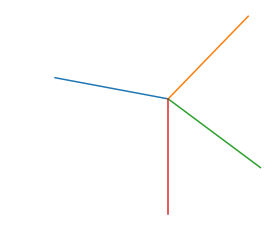

In [264]:
# Plot the Normals
BndryNormals = bndryNormals(newVertices)
for i in range(4):
    plt.plot([0,BndryNormals[i][0]], [0,BndryNormals[i][1]])

plt.axis('scaled')                      # Trim the white space
plt.axis('off')                         # Turn off the framing
plt.savefig("./figures/FaceNormals.pdf", bbox_inches='tight')

[[   -0.01125013 -5260.99599688 -1513.70199164   417.6719    ]
 [ -428.99622758 -4810.29147529 -1241.24897727   244.318     ]
 [-1874.478704   -3904.64293009     0.03356886   382.7421    ]
 [-1249.65194852 -3997.47265745  -694.0002935    -29.1003    ]
 [ -624.82527296 -4090.3022434  -1388.0341354   -440.9428    ]
 [    0.00148252 -4183.13197076 -2082.06799777  -852.7852    ]
 [-2307.35253229 -2928.4826711      0.04134317  -406.7067    ]
 [-1538.23028926 -2987.41111956  -883.45041928  -978.8852    ]
 [ -769.10802785 -3046.33949619 -1766.94224145 -1551.0638    ]
 [    0.01421518 -3105.26794464 -2650.4340039  -2123.2423    ]
 [-2740.22647726 -1952.32241438     0.04925741 -1196.1554    ]
 [-1826.80863    -1977.34958168 -1072.90054505 -1928.6701    ]
 [ -913.39089943 -2002.37675123 -2145.85020757 -2661.1847    ]
 [    0.02694783 -2027.40391852 -3218.80001002 -3393.6994    ]
 [-3173.10030555  -976.1621554      0.05703172 -1985.6042    ]
 [-2376.3477708   -971.52203717  -949.80925223 -2655.75

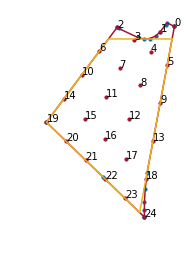

In [273]:
BndryNormals = bndryNormals(newVertices)
[faceDist, bInside] = calcDistNorms(x0s, newVertices, BndryNormals)
np.set_printoptions(suppress=True)
print(faceDist)
print(bInside)

printBoundaryClr(clsdBP, colorNum)
#printTurbines(clsdBP, getPltClrs().getColor(5), 10) # Print the boundary verticies
printBoundaryClr(newVertices, colorNum+1)
printTurbines(x0s, getPltClrs().getColor(1), 10, True)
plt.savefig("./figures/BoundaryNumberedTurbs.pdf", bbox_inches='tight')

It seems to be calculating and plotting correctly, but for some reason the turbines on the boundary are showing as just 'out'. This can be due two three possible reasons:
1. The original turbine locations were't actually on the boundary
2. The modified boundary isn't perfectly in line with the old one
3. Error in the normal calculation that is giving a false negative
As a quick-fix, I have given a bit of tolerance (0.09) to permit these on the boundary to be read as "in"

`0904.26.Mar.20`

#### 1) Were original turbines out of bounds?
Let's graph it thin:

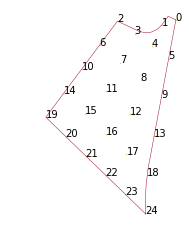

In [209]:
printTurbines(x0s, getPltClrs().getColor(2), 0.1, True)
plt.plot(clsdBP.x, clsdBP.y, color=getPltClrs().getColor(colorNum), linewidth=.5)
plt.axis('scaled')                      # Trim the white space
plt.axis('off')                         # Turn off the framing
#plt.savefig("./figures/TempThin.pdf", bbox_inches='tight')

Turbine #5 might actually be out of bounds. Let's take a look at that one.

In [221]:
def getPtSlopeFromPts(pt1, pt2):
    m = (pt1.y-pt2.y)/(pt1.x-pt2.x)
    b = (pt1.x*pt2.y - pt2.x*pt1.y)/(pt1.x-pt2.x)
    return m, b

Boundary endpoints:
(10363.8, 6490.3)
(9449.7, 1602.2)

Right bndry eq: y = 5.347445574882407x + -48929.55644896628

10126.2142
Turbine coord is: [10126.2142  5219.8148]
Turbine coord should be: [10126.2142, 5219.822865135116]


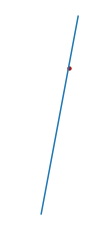

In [262]:
TurbNum= 5

print("Boundary endpoints:")
print(clsdBP[0])
print(clsdBP[1])
print()
[m,b] = getPtSlopeFromPts(clsdBP[0], clsdBP[1])
print("Right bndry eq: y = " + str(m) + "x + " + str(b))

x_vals = np.linspace(clsdBP[1].x,clsdBP[0].x)
abline_values = [m * i + b for i in x_vals]

print()
print(turb_coords[TurbNum][0])
print("Turbine coord is: " + str(turb_coords[TurbNum]))
newPt = [turb_coords[TurbNum][0],((turb_coords[TurbNum][0]*m) + b)]
print("Turbine coord should be: " + str(newPt))

plt.hold = True
plt.plot(x_vals, abline_values)
plt.scatter(turb_coords[TurbNum][0], turb_coords[TurbNum][1], s=10, color=getPltClrs().getColor(2))
plt.scatter(newPt[0], newPt[1], s=10, color=getPltClrs().getColor(1))
plt.axis('scaled')                      # Trim the white space
plt.axis('off')                         # Turn off the framing
plt.savefig("./figures/TempZoom.pdf", bbox_inches='tight')

`1003.26.Mar.20`

Well It's official.
I gave example turbines that are out of bounds.
What I think happepend is that when I generated them, they were in bounds, but when I scaled everything down (the boundary and locations) so that there was an increased turbine density, the rounding error pushed the turbines on the line just out of bounds, by a value of about ~0.05m. (about two inches). It's too late now since the example is already propogated, but I now know that the code for determining out of bounds is working and that as a starting point, some points are invalid and the optimizer needs to push stuff in.

I'll try it again for pt 9 just to make sure:

Boundary endpoints:
(6098.3, 3297.5)
(8450.3, 6455.3)

Right bndry eq: y = 1.342602040816327x + -4890.090025510209

7862.2807
Turbine coord is: [7862.2807 5665.8933]
Turbine coord should be: [7862.2807, 5665.824087780612]


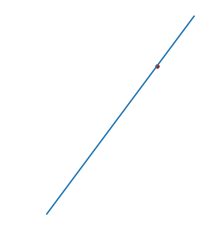

In [275]:
TurbNum= 6

print("Boundary endpoints:")
print(clsdBP[8])
print(clsdBP[9])
print()
[m,b] = getPtSlopeFromPts(clsdBP[8], clsdBP[9])
print("Right bndry eq: y = " + str(m) + "x + " + str(b))

x_vals = np.linspace(clsdBP[9].x,clsdBP[8].x)
abline_values = [m * i + b for i in x_vals]

print()
print(turb_coords[TurbNum][0])
print("Turbine coord is: " + str(turb_coords[TurbNum]))
newPt = [turb_coords[TurbNum][0],((turb_coords[TurbNum][0]*m) + b)]
print("Turbine coord should be: " + str(newPt))

plt.hold = True
plt.plot(x_vals, abline_values)
plt.scatter(turb_coords[TurbNum][0], turb_coords[TurbNum][1], s=10, color=getPltClrs().getColor(2))
plt.scatter(newPt[0], newPt[1], s=10, color=getPltClrs().getColor(1))
plt.axis('scaled')                      # Trim the white space
plt.axis('off')                         # Turn off the framing
plt.savefig("./figures/TempZoom.pdf", bbox_inches='tight')